In [1]:
import os
from pathlib import Path

if "PROJECT_ROOT" not in globals():
    PROJECT_ROOT = Path.cwd().parent.resolve()

os.chdir(PROJECT_ROOT)

In [2]:
from src import dumpy
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import torch
from torch import Tensor

## Load data

In [3]:
test_data = pd.read_csv("ignore/translation_test.csv", index_col=0, dtype=str)
cancer_test_data = pd.read_csv("ignore/translation_cancer.csv", index_col=0, dtype=str)
alphabet = pd.read_csv("model_saves/alphabet.csv", index_col=0)

In [19]:
test_data = pd.concat([test_data, cancer_test_data], axis=0)

In [20]:
test_data.head()

,Unnamed: 0,Studies,Assays,TCR species,CDR3A,CDR3B,TRAV,TRBV,epitope,MHCA,MHCB,MHC class,CDR3B_length,epitope_length,translation_CDR3B,translation_epitope
0,164,PMID:28636589,tetramer-sort,HomoSapiens,NaN,QSRSSYNEQF,NaN,TRBV4-1*01,EHDTL,HLA-A*01:01,B2M,1.0,15,9,1111110110,11000
1,901,PMID:28636589,multimer/tetramer,HomoSapiens,NaN,LSGLGDNEQF,NaN,TRBV7-3,EHDTL,HLA-A*01:01,B2M,1.0,15,9,0110100110,11000
2,1001,PMID:32793919,High throughput multiplexed assay,HomoSapiens,NaN,STGDYADGYT,NaN,TRBV4-2,DGVPF,NaN,B2M,1.0,15,9,1010100110,01000
3,1684,PMID:32793919,High throughput multiplexed assay,HomoSapiens,NaN,HPGISGNTIY,NaN,TRBV11-3,DGVPF,NaN,B2M,1.0,15,9,1010110001,01000
4,1763,PMID:34811538,tetramer-sort,HomoSapiens,CILRDSAGGTSYGKLTF,HGRGFQETQY,TRAV26-2*01,TRBV4-3*01,RGRAY,HLA-B*08:01,B2M,1.0,15,9,1111011011,11101


In [21]:
alphabet

,A,C,D,E,F,G,H,I,K,L,M,N,P,Q,R,S,T,V,W,Y
Letter,0,1,0,1,0,1,1,0,1,0,0,0,0,1,1,1,0,0,0,1


In [22]:
epitope_priors = dumpy.compute_epitope_priors_from_alphabet(alphabet)

In [23]:
# Turn translated sequences into torch tensors
def map_zero_one_string_to_tensor(zero_one_string: str) -> Tensor:
    return torch.tensor([float(char) for char in zero_one_string])

tcr_tensor_test = torch.stack(test_data["translation_CDR3B"].map(map_zero_one_string_to_tensor).tolist())
epitope_tensor_test = torch.stack(test_data["translation_epitope"].map(map_zero_one_string_to_tensor).tolist())

## Load model save

In [24]:
dp = dumpy.Dumpy(5, 10)
dp.load_state_dict(torch.load("model_saves/dumpy_of_choice.pth", weights_only=True))

<All keys matched successfully>

In [25]:
dp_joint = dumpy.DumpyJoint(dp, epitope_priors)

## AUCs

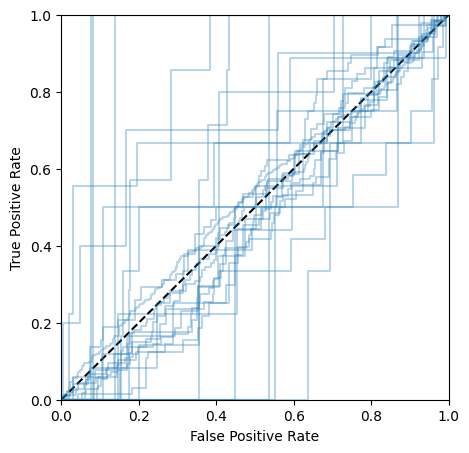

In [30]:
plt.figure(figsize=(5,5))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.xlim(0,1)
plt.ylim(0,1)
plt.plot([0,1], [0,1], linestyle="--", c="black")

aucs = []

unique_epitopes_test = test_data["translation_epitope"].unique()
all_epitopes_test = epitope_tensor_test.unique(dim=0)

for epitope in unique_epitopes_test:
    if epitope == "01011":
        continue

    positive_indices = (test_data["translation_epitope"] == epitope).to_numpy()
    negative_indices = ~positive_indices

    positive_tcrs = tcr_tensor_test[positive_indices]
    negative_tcrs = tcr_tensor_test[negative_indices]
    target_epitope = epitope_tensor_test[positive_indices][:1]

    p_target_ep_positives = dp_joint.joint(positive_tcrs, target_epitope).squeeze()
    p_all_eps_positives = dp_joint.joint(positive_tcrs, all_epitopes_test).sum(dim=1)
    p_target_ep_positives_normalized = p_target_ep_positives / p_all_eps_positives # Relative prob of target epitope out of all possible

    p_target_ep_negatives = dp_joint.joint(negative_tcrs, target_epitope).squeeze()
    p_all_eps_negatives = dp_joint.joint(negative_tcrs, all_epitopes_test).sum(dim=1)
    p_target_ep_negatives_normalized = p_target_ep_negatives / p_all_eps_negatives # Same as above, but for negative TCRs

    all_positive_probs = torch.concatenate((p_target_ep_positives_normalized, p_target_ep_negatives_normalized))
    all_labels = torch.concatenate((torch.ones_like(p_target_ep_positives_normalized), torch.zeros_like(p_target_ep_negatives_normalized)))

    fprs, tprs, _ = metrics.roc_curve(all_labels, all_positive_probs)
    auc = metrics.roc_auc_score(all_labels, all_positive_probs)
    aucs.append(auc)

    plt.step(fprs, tprs, c="C0", alpha=0.3)

plt.show()

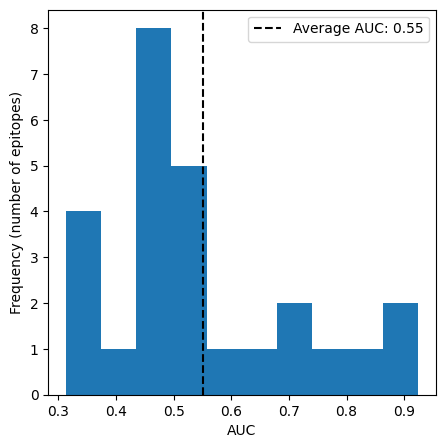

In [31]:
average_auc = np.mean(aucs)

plt.figure(figsize=(5,5))
plt.hist(aucs)
plt.axvline(average_auc, c="black", linestyle="--", label=f"Average AUC: {average_auc:.2f}")
plt.xlabel("AUC")
plt.ylabel("Frequency (number of epitopes)")
plt.legend()
plt.show()